## Nombre: Pablo Segovia
### CEIA - Aprendizaje de Máquina 1
#### Dataset: [Credit Profile](https://www.kaggle.com/datasets/yashkmd/credit-profile-two-wheeler-loan-dataset)
- Obtenido de Kaggle.
- La descripción detallada de cada feature, se encuentra en el siguiente apartado.

### About Dataset
This dataset provides a comprehensive overview of potential loan applicants' profiles, specifically tailored for the Indian demographic. It encapsulates a range of features, from basic demographics to financial details, that can be instrumental in assessing the creditworthiness of an individual.

#### Age:
- Type: Integer
- Description: Represents the age of the applicant. Indicates the applicant's maturity level.
- Range: 18 to 70

#### Gender:
- Type: Categorical
- Description: Gender of the applicant.
- Categories: Male, Female, Other

#### Income:
- Type: Integer
- Description: The applicant's income, which is critical in assessing their ability to repay the loan.
- Range: Multiples of 1000's

#### Credit Score:
- Type: Integer
- Description: A score quantifying the applicant's creditworthiness based on their credit history.
- Range: 300 to 850

#### Credit History Length:
- Type: Integer
- Description: Represents the number of months since the applicant's first credit line. Indicates the applicant's experience with credit management.
- Units: Months

#### Number of Existing Loans:
- Type: Integer
- Description: The number of loans the applicant currently has.
- Range: 0 to 10

#### Loan Amount:
- Type: Integer
- Description: The amount of money the applicant is requesting.
- Range: 0 to 150,000

#### Loan Tenure:
- Type: Integer
- Description: The number of months the applicant wants to repay the loan over.
- Units: Months

#### Existing Customer:
- Type: Categorical
- Description: Whether the applicant is an existing customer of the finance company.
- Categories: Yes, No

#### State:
- Type: Categorical
- Description: The state in India where the applicant resides.
- Categories: Maharashtra, Delhi, Karnataka, Tamil Nadu, West Bengal, Uttar Pradesh, Gujarat, Rajasthan, Kerala, Telangana, etc.

#### City:
- Type: Categorical
- Description: The city or village in India where the applicant resides.
- Categories: Mumbai, Pune, New Delhi, Bengaluru, Chennai, Kolkata, Ahmedabad, Jaipur, Kochi, Hyderabad, and various villages.

#### LTV Ratio:
- Type: Float
- Description: The loan-to-value ratio, represents the ratio of the loan amount to the appraised value of the asset (typically a house). Higher LTVs can indicate higher risk.
- Range: 40% to 95%

#### Employment Profile:
- Type: Categorical
- Description: General employment category of the applicant.
- Categories: Salaried, Self-Employed, Freelancer, Unemployed, Student

#### Occupation:
- Type: Categorical
- Description: Specific occupation or job title of the applicant.
- Categories: Software Engineer, Doctor, Teacher, Business Owner, Writer, etc.

#### Profile Score:
- Type: Integer
- Description: A score ranging from 0 to 100 represents the overall profile of the applicant based on the actual loan repayment data. Higher values indicate better profiles.
- Range: 0 to 100

## Propuesta de Investigación
### Idea General de desarrollo

Como idea general, se buscaba un dataset que permita hacer hincapié en todos los modelos vistos en la asignatura:
- Regresión.
- Clasificación.

Para ello, se usará la variable `Credit Score` como target, aplicando modelos de regresión sobre ésta y luego enmascarándola para poder aplicar los modelos de clasificación.

### Criterio de uso de la máscara

La variable `Credit Score` tendrá una máscara dividida en el 75% del rango del score. ¿Qué quiere decir?

Como este label representa si una persona es digna de crédito o no, podemos usar este umbral para no tomar personas que puedan fallar al pago pero si que exista un buen número de clientes habilitados, no dando chances a unos pocos. Este criterio, podrá ser presentado luego ante el Management del banco para adaptar los modelos finales ante conocimiento experto.

### ¿Qué se busca?
Encontrar el mejor algoritmo de regresión y de clasificación para el set de datos.

### Importamos librerías

In [1]:
# Importamos librerías
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import torch

In [2]:
# Importamos librerías de sklearn
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, PowerTransformer
from sklearn.preprocessing import PolynomialFeatures

# Importamos de selección de modelo
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold, RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Importamos modelos lineales
from sklearn.linear_model import LogisticRegression, LinearRegression

# Importamos métricas
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.metrics import classification_report, confusion_matrix, auc, roc_curve, ConfusionMatrixDisplay

# Importamos modelos de clasificación
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Pipelines
from sklearn.pipeline import Pipeline

### Importamos funciones de cálculo

In [3]:
# Sklean no tiene el error porcentual medio (MPE) lo vamos a crear nosotros
def mean_porcentual_error(yreal, ypred):

    return np.mean((yreal-ypred)/yreal)

In [4]:
class feed_foward(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.layers = torch.nn.Sequential(
            torch.nn.Linear(22, 7),
            torch.nn.ReLU(),
            torch.nn.Linear(7, 1),
            torch.nn.Sigmoid()
        )
        
    #Define a la parte de prediccion
    def forward(self, x):

        # Pasamos por el perceptron
        y_prob = self.layers(x)

        return y_prob
    
    def digital_out(self, x):

        y_prob = self.layers(x)

        return torch.heaviside((y_prob * 2) - 1, values=torch.tensor(0.))

### Importamos Dataset

In [5]:
credit = pd.read_csv('credit_data.csv')

### Exploramos dataset

In [6]:
# Vemos las primeras 5 filas
credit.head()

,Age,Gender,Income,Credit Score,Credit History Length,Number of Existing Loans,Loan Amount,Loan Tenure,Existing Customer,State,City,LTV Ratio,Employment Profile,Profile Score,Occupation
0,31,Male,36000,604,487,5,109373,221,No,Karnataka,Mysuru,90.943430,Salaried,77,Doctor
1,25,Male,50000,447,386,2,150000,89,No,Karnataka,Bengaluru,91.135253,Salaried,43,Software Engineer
2,62,Other,178000,850,503,10,69099,110,Yes,Uttar Pradesh,Kanpur,40.000000,Salaried,90,Banker
3,69,Female,46000,668,349,6,150000,148,Yes,Karnataka,Bengaluru,87.393365,Self-Employed,86,Contractor
4,52,Male,132000,601,553,5,150000,157,No,Karnataka,Mysuru,66.158757,Salaried,90,Teacher


In [7]:
credit.shape

(279856, 15)

In [8]:
# Analizamos la información de las columnas
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279856 entries, 0 to 279855
Data columns (total 15 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Age                       279856 non-null  int64  
 1   Gender                    279856 non-null  object 
 2   Income                    279856 non-null  int64  
 3   Credit Score              279856 non-null  int64  
 4   Credit History Length     279856 non-null  int64  
 5   Number of Existing Loans  279856 non-null  int64  
 6   Loan Amount               279856 non-null  int64  
 7   Loan Tenure               279856 non-null  int64  
 8   Existing Customer         279856 non-null  object 
 9   State                     279856 non-null  object 
 10  City                      279856 non-null  object 
 11  LTV Ratio                 279856 non-null  float64
 12  Employment Profile        279856 non-null  object 
 13  Profile Score             279856 non-null  i

In [9]:
# Analizamos los valores nulos para saber si se pueden imputar
credit.isnull().sum()

Age                             0
Gender                          0
Income                          0
Credit Score                    0
Credit History Length           0
Number of Existing Loans        0
Loan Amount                     0
Loan Tenure                     0
Existing Customer               0
State                           0
City                            0
LTV Ratio                       0
Employment Profile              0
Profile Score                   0
Occupation                  18272
dtype: int64

- Vemos que la única columna con valores nulos es la de Occupation

In [10]:
# Vemos qué contiene esa columna
credit.Occupation.value_counts()

Occupation
Banker                    27760
Teacher                   27356
Civil Servant             27221
Software Engineer         27146
Doctor                    26582
Shopkeeper                21405
Contractor                21090
Farmer                    20966
Business Owner            20908
Student                   18521
Graphic Designer           5723
Photographer               5706
Independent Consultant     5628
Writer                     5572
Name: count, dtype: int64

In [11]:
# Pérdida de valores quitando los valores nulos
print("Pérdida de valores al quitar los nulos en Occupation: ", 100*(credit.Occupation.isna().sum() / len(credit.Occupation)), " %")

Pérdida de valores al quitar los nulos en Occupation:  6.5290720942198845  %


#### Tratamiento de valores nulos
- Con este valor de nulos intermedio en frecuencia a las ocupaciones, podríamos imputar los nulos como otra ocupación: `Other`.
- Este valor `Other` implica otras ocupaciones más los clientes que no tienen una ocupación o no quisieron dar detalles de la misma.
- Recordemos que esto puede generar un cambio en la distribución de los valores de las otras variables, por lo que podemos optar también de quitarlos.
- Quitar estas filas, supone una pérdida de 6.53 % del dataset.
- Igualmente, se decide avanzar con estos datos como `Other` en caso que un nuevo cliente se califique como tal.

In [12]:
# Imputamos los valores nulos como otros
credit.Occupation = credit.Occupation.fillna('Other')

In [13]:
# Ahora vemos si forma parte de la categorización
credit.Occupation.value_counts()

Occupation
Banker                    27760
Teacher                   27356
Civil Servant             27221
Software Engineer         27146
Doctor                    26582
Shopkeeper                21405
Contractor                21090
Farmer                    20966
Business Owner            20908
Student                   18521
Other                     18272
Graphic Designer           5723
Photographer               5706
Independent Consultant     5628
Writer                     5572
Name: count, dtype: int64

- Efectivamente vemos que están presentes.

### Separamos las variables
- En este apartado, vamos a revisar todas las variables para conocer su distribución y ver si es necesario realizar un feature engineering para contar con un mejor uso de ellas en los modelos a analizar.

### Age

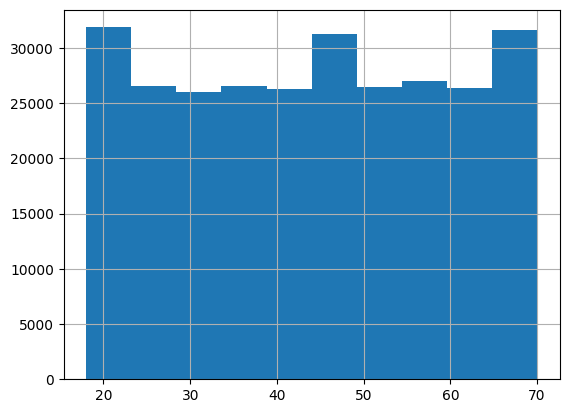

In [14]:
# Vemos Age
credit.Age.hist();

In [15]:
sorted(credit.Age.unique().tolist())[:3], sorted(credit.Age.unique().tolist())[-3:]

([18, 19, 20], [68, 69, 70])

- Esta variable es entera (numérica).
- Se puede decir que tiene una distribución uniforme.
- Va desde los 18 hasta los 70 años.

#### Gender

In [16]:
# Vemos Gender
credit.Gender.value_counts()

Gender
Female    133145
Male      132749
Other      13962
Name: count, dtype: int64

In [17]:
# Veamos cuánto representa "Other" en el total
credit.Gender[credit.Gender == "Other"].value_counts() / len(credit)

Gender
Other    0.04989
Name: count, dtype: float64

- Vemos que hombres y mujeres está equilibrado.
- Vemos que otros representa solo el 5% del total.

#### Income

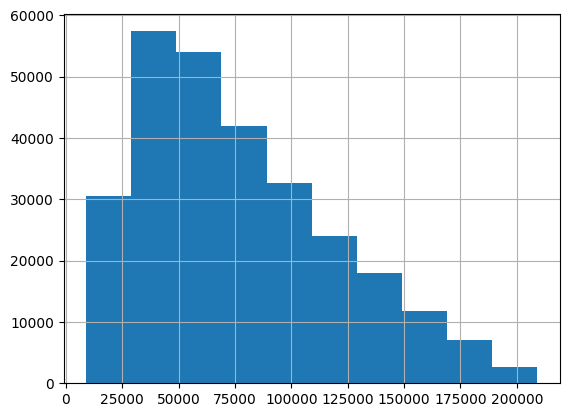

In [18]:
# Vemos cómo están distribuidos los datos
credit.Income.hist();

In [19]:
# Vemos el skewness
credit.Income.skew()

0.7087788559099581

- Tienen una distribución conocida con skewness 0.71.
- Podemos hacer una transformación al momento de utilizarlo en un modelo lineal.

#### Credit score (nuestro Label)

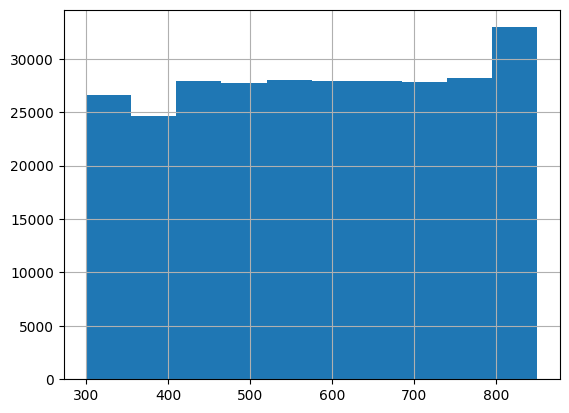

In [20]:
credit['Credit Score'].hist();

- Vemos que también tiene una distribución uniforme.

#### Credit history length

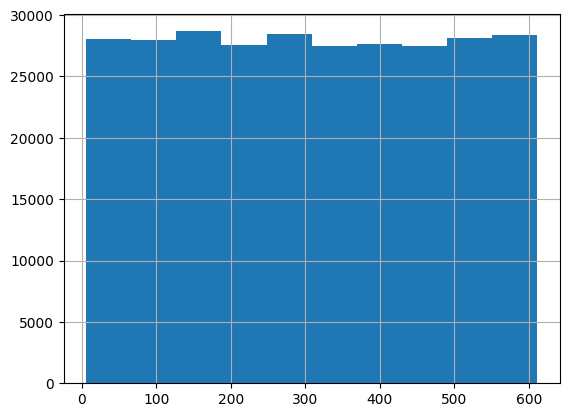

In [21]:
credit['Credit History Length'].hist();

- Vemos que también la distribución de esta variable es uniforme.

#### Number of Existing Loans

In [22]:
credit['Number of Existing Loans'].value_counts()

Number of Existing Loans
8     28184
4     28059
2     27968
6     27955
5     27950
7     27792
3     27745
0     26590
1     24656
9     17332
10    15625
Name: count, dtype: int64

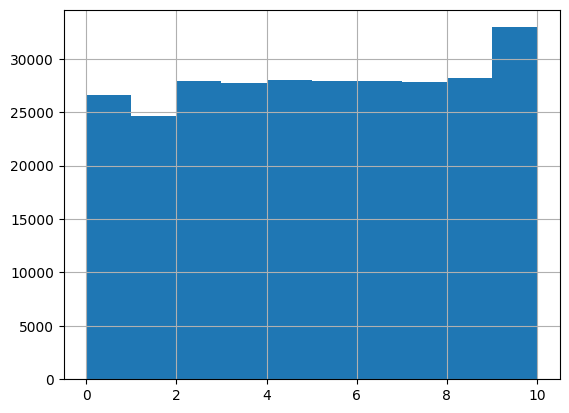

In [23]:
credit['Number of Existing Loans'].hist();

- Vemos que es una variable discreta.
- La distribución es uniforme.
- Podemos considerarla categórica.

#### Loan amount

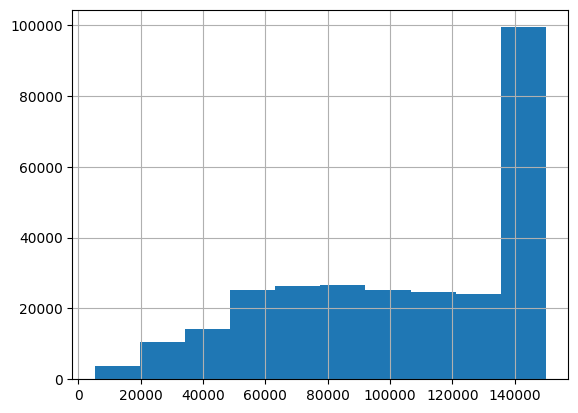

In [24]:
credit['Loan Amount'].hist();

- Uno de los valores es el más frecuente. Lo podemos aislar o podemos realizarle una transformación logarítmica y ver cómo se modifica.
- Haciendo una transformación logarítmica, tenemos lo siguiente:

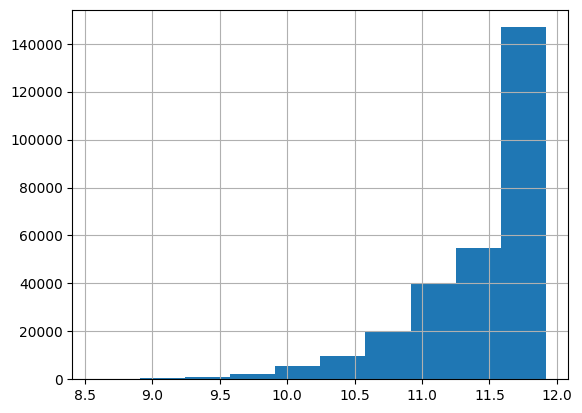

In [25]:
log_loan_amount = np.log(credit['Loan Amount'])
log_loan_amount.hist();

In [26]:
# Calculamos skewness y vemos si se puede normalizar
log_loan_amount.skew()

-1.3901725049556157

- Podríamos aplicar una transformación Yeo-Johnson al usarlo dentro de los modelos.
- En caso de no hacerle ninguna transformación, podemos ver si genera algun impacto realizando una máscara:

In [27]:
# Analizamos el valor donde cortar la máscara
credit['Loan Amount'].value_counts()

Loan Amount
150000    76042
51258        20
127479       15
56174        15
138647       15
          ...  
88176         1
115588        1
63994         1
106514        1
15977         1
Name: count, Length: 55681, dtype: int64

In [28]:
# Vemos que hay muchos préstamos que son 150000
credit['Loan Amount'][credit['Loan Amount'] != 150000].value_counts().sum()

203814

In [29]:
# Vemos que hay muchos préstamos que son 150.000
credit['Loan Amount'][credit['Loan Amount'] == 150000].value_counts().sum()

76042

In [30]:
# Definimos la máscara para los que son 150000 y los que no
mask_loan = credit['Loan Amount'].copy()
mask_loan_value = 150000
mask_loan = mask_loan.apply(lambda x: 1 if x>=mask_loan_value else 0)
mask_loan.value_counts() / len(credit)

Loan Amount
0    0.728282
1    0.271718
Name: count, dtype: float64

- En caso de enmascarar a este valor, tenemos una buena diferenciación de clases en %.
- Podemos ver mientras desarrollamos el análisis si tiene más peso esta máscara o los valores crudos.

#### Loan tenure

In [31]:
credit['Loan Tenure'].value_counts()

Loan Tenure
100    1971
96     1952
81     1930
63     1921
73     1906
       ... 
250     354
301     353
324     348
255     343
319     337
Name: count, Length: 348, dtype: int64

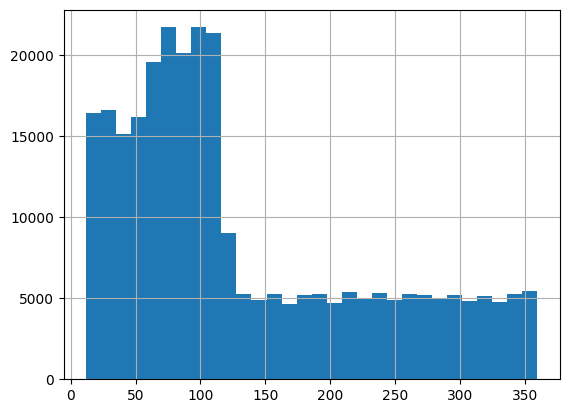

In [32]:
credit['Loan Tenure'].hist(bins=30);

- Vemos que tiene una distribución poco conocida, pero podríamos separar los valores y definirlo como una categoría siguiendo los pasos de `Loan Amount`.
- Al ser meses, podemos ver de reemplazar por un valor umbral lógico.

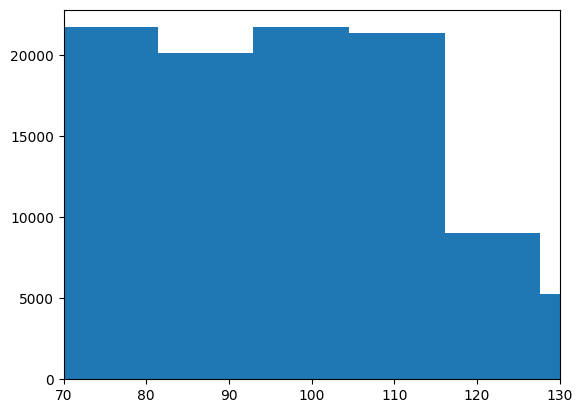

In [33]:
plt.hist(credit['Loan Tenure'], bins=30)
plt.xlim([70,130])
plt.show()

- Vemos que el corte ronda los 100.
- 10 años son 120 meses, por lo que podemos usar este valor de 120 para hacer el corte.
- Analizamos si queda equilibrado el feature cortando en ese valor.

In [34]:
# Definimos la máscara para los que son menores a 120 y los que no
mask_tenure = credit['Loan Tenure'].copy()
mask_tenure_value = 120
mask_tenure = mask_tenure.apply(lambda x: 1 if x<=mask_tenure_value else 0)
mask_tenure.value_counts() / len(credit)

Loan Tenure
1    0.62425
0    0.37575
Name: count, dtype: float64

- Podemos decir que haciendo un corte en este valor umbral de 120 quedamos prácticamente equilibrados.

#### Existing costumer

In [35]:
credit['Existing Customer'].value_counts()

Existing Customer
No     173952
Yes    105904
Name: count, dtype: int64

In [36]:
credit['Existing Customer'].value_counts()/len(credit)

Existing Customer
No     0.621577
Yes    0.378423
Name: count, dtype: float64

- Es una variable booleana.
- Está equilibrada ~ 60/40.

#### State

In [37]:
credit.State.value_counts()

State
Karnataka        28245
Telangana        28101
Maharashtra      28095
Gujarat          28051
West Bengal      28050
Tamil Nadu       28022
Kerala           28011
Delhi            27996
Uttar Pradesh    27713
Rajasthan        27572
Name: count, dtype: int64

- Todas las clases están equilibradas.

#### City

In [38]:
credit.City.value_counts()

City
Kolkata               23900
New Delhi             23887
Hyderabad             23726
Mysuru                12227
Udaipur               12012
Kanpur                12001
Surat                 11969
Thiruvananthapuram    11966
Coimbatore            11907
Ahmedabad             11896
Chennai               11797
Bengaluru             11777
Kochi                 11748
Lucknow               11682
Jaipur                11482
Dhulagori              8527
Manjari                8483
Bishanpura             8396
Nellikuppam            8341
Channarayapatna        8242
Mumbai                 8093
Nagpur                 7923
Pune                   7874
Name: count, dtype: int64

- Se puede decir que la cuenta de préstamos respecto la ciudad no está del todo desequilibrada.
- Si bien solo son 3 las ciudades que tienen más de 20.000 préstamos, habría que enteder si es necesario cruzar estos datos con la cantidad de habitantes de cada ciudad para ver si es significativo.
- Se puede plantear para un próximo problema, fuera del scope de este práctico, si hay significación ante la población de cada ciudad y este feature.

#### LTV ratio

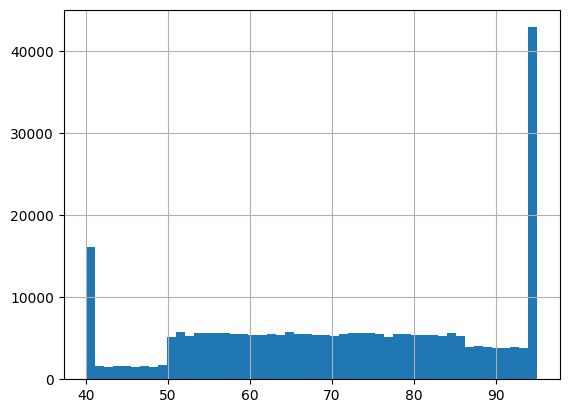

In [39]:
credit['LTV Ratio'].hist(bins=50);

In [40]:
credit['LTV Ratio'].value_counts()

LTV Ratio
95.000000    38991
40.000000    14388
90.943430        3
92.201528        3
69.425639        3
             ...  
72.678303        1
87.477804        1
62.629332        1
89.695233        1
66.329921        1
Name: count, Length: 80874, dtype: int64

- Cuenta con una distribución muy extraña.
- Del detalle del dataset, este feature describe que mientras más alto el valor de LTV, más alto el riesgo del préstamos.
- Se puede plantear hacer una máscara con riesgos mayores a 80% y definir si es riesgoso (mayor a este valor) o no.
- De esta forma dejamos una categoría con mejor comprensión.

In [41]:
# Definimos la máscara para los que son mayores a 80 y los que no
mask_ltv = credit['LTV Ratio'].copy()
mask_ltv_value = 80
mask_ltv = mask_ltv.apply(lambda x: 1 if x>=mask_ltv_value else 0)
mask_ltv.value_counts() / len(credit)

LTV Ratio
0    0.640976
1    0.359024
Name: count, dtype: float64

- Así, vemos que el 36% son riesgosos y el resto no.
- Queda bastante equilibrado el feature de esta manera.

#### Employment profile

In [42]:
credit['Employment Profile'].value_counts()

Employment Profile
Salaried         136065
Self-Employed     84369
Freelancer        22629
Student           18521
Unemployed        18272
Name: count, dtype: int64

In [43]:
# Analizamos en porcentajes como están distribuidos
credit['Employment Profile'].value_counts()/len(credit)

Employment Profile
Salaried         0.486196
Self-Employed    0.301473
Freelancer       0.080859
Student          0.066180
Unemployed       0.065291
Name: count, dtype: float64

- La gran mayoría es o asalariado y auto-empleado.
- Podemos dejar el resto de los perfiles para tener una mejor explicabilidad.

#### Profile score

In [44]:
credit['Profile Score'].value_counts()

Profile Score
100    58495
90      8362
98      8284
95      8257
94      8176
       ...  
3        194
4        189
5        173
2        137
1        119
Name: count, Length: 101, dtype: int64

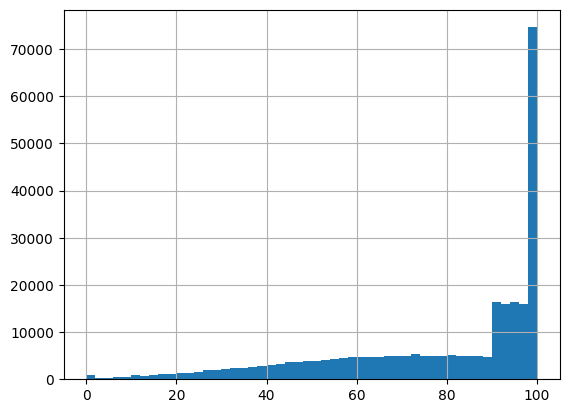

In [45]:
credit['Profile Score'].hist(bins=50);

- Del último histograma se ve que hay un cambio en la distribución a valores mayores a 90.
- Se puede probar agrupando en dos categorías y chequear si estan balanceados.
- Los que tengan un score mayor a este valor, serán excelentes.

In [46]:
# Definimos la máscara para los que son mayores a 90 y los que no
mask_profile = credit['Profile Score'].copy()
mask_profile_value = 90
mask_profile = mask_profile.apply(lambda x: 1 if x>=mask_profile_value else 0)
mask_profile.value_counts() / len(credit)

Profile Score
0    0.502487
1    0.497513
Name: count, dtype: float64

- Vemos que quedan balanceados con este score.

#### Occupation

In [47]:
credit.Occupation.value_counts()

Occupation
Banker                    27760
Teacher                   27356
Civil Servant             27221
Software Engineer         27146
Doctor                    26582
Shopkeeper                21405
Contractor                21090
Farmer                    20966
Business Owner            20908
Student                   18521
Other                     18272
Graphic Designer           5723
Photographer               5706
Independent Consultant     5628
Writer                     5572
Name: count, dtype: int64

- Ya analizamos que el valor Other era significativo.
- Se dejará de esta manera.

## Elegimos nuestro X y nuestro y
### Analizamos primero con los features originales para entender cómo aplicar modelos.

In [48]:
X = credit.drop('Credit Score', axis=1)
y = credit['Credit Score']

In [49]:
# Chequeamos cómo queda
X.shape, y.shape

((279856, 14), (279856,))

### Realizamos el split
- Hacemos un split de 70/30 por la gran cantidad de datos.
- Tenemos que elegir un seed que nos permita mantener un cierto equilibrio.

In [50]:
seed = 17
train_split = 0.7
test_split = 1 - train_split

In [51]:
# Separando nuestro dataset en entrenamiento y testeo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_split, random_state=seed)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((195899, 14), (83957, 14), (195899,), (83957,))

## Regresión

- Para hacer regresión, tenemos que separar los features que son numéricos

In [52]:
# Definimos variables según su tipo
numericas = ['Age', 'Income', 'Credit History Length', 'Loan Amount', 'Loan Tenure', 'LTV Ratio', 'Profile Score']
categoricas = ['Gender', 'Existing Customer','Number of Existing Loans', 'State', 'City', 'Employment Profile', 'Occupation']

#### Con features numéricas

In [53]:
# Plantemos una regresión en general con las numéricas
lin_reg = LinearRegression()
lin_reg.fit(X_train[numericas], y_train)

LinearRegression()

In [54]:
#Primero obtenemos las predicciones del modelo
y_pred = lin_reg.predict(X_test[numericas])

# Calculamos las métricas
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred)
mpe = mean_porcentual_error(y_test, y_pred)
print("R-cuadrado en test:", r2)
print("Error absoluto medio:", mae)
print("Error cuadratico medio:", mse)
print("Raiz de error cuadratico medio:", rmse)
print(f"Error absoluto porcentual medio: {mape*100:.2f}%")
print(f"Error porcentual medio: {mpe*100:.2f}%")

R-cuadrado en test: 0.6998765464962519
Error absoluto medio: 72.3002707472584
Error cuadratico medio: 7957.877919990331
Raiz de error cuadratico medio: 89.20693874352114
Error absoluto porcentual medio: 13.47%
Error porcentual medio: -2.50%


- Con los features numéricos, tenemos unos scores bajos.
- Esto significa, que no hay explicabilidad suficiente solo usando estos features.

### Analizamos correlación de variables entre las numericas y quitamos una de las que tienen correlación entre sí

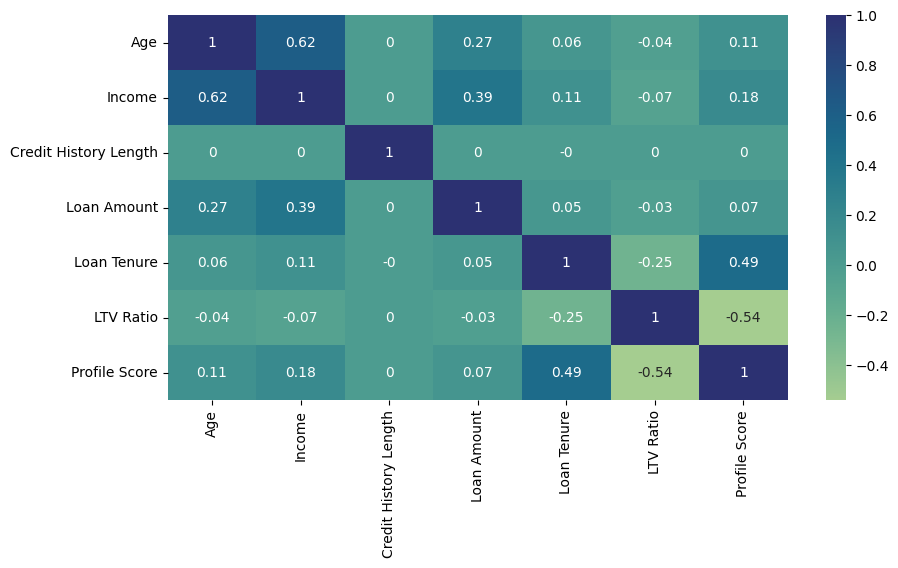

In [55]:
# Matriz de correlación, redondeo a 2 decimales
correlation_matrix = credit[numericas].corr().round(2)
fig,axes = plt.subplots(1,1,figsize=(10,5))
sns.heatmap(data=correlation_matrix, annot=True,ax=axes, cmap='crest');

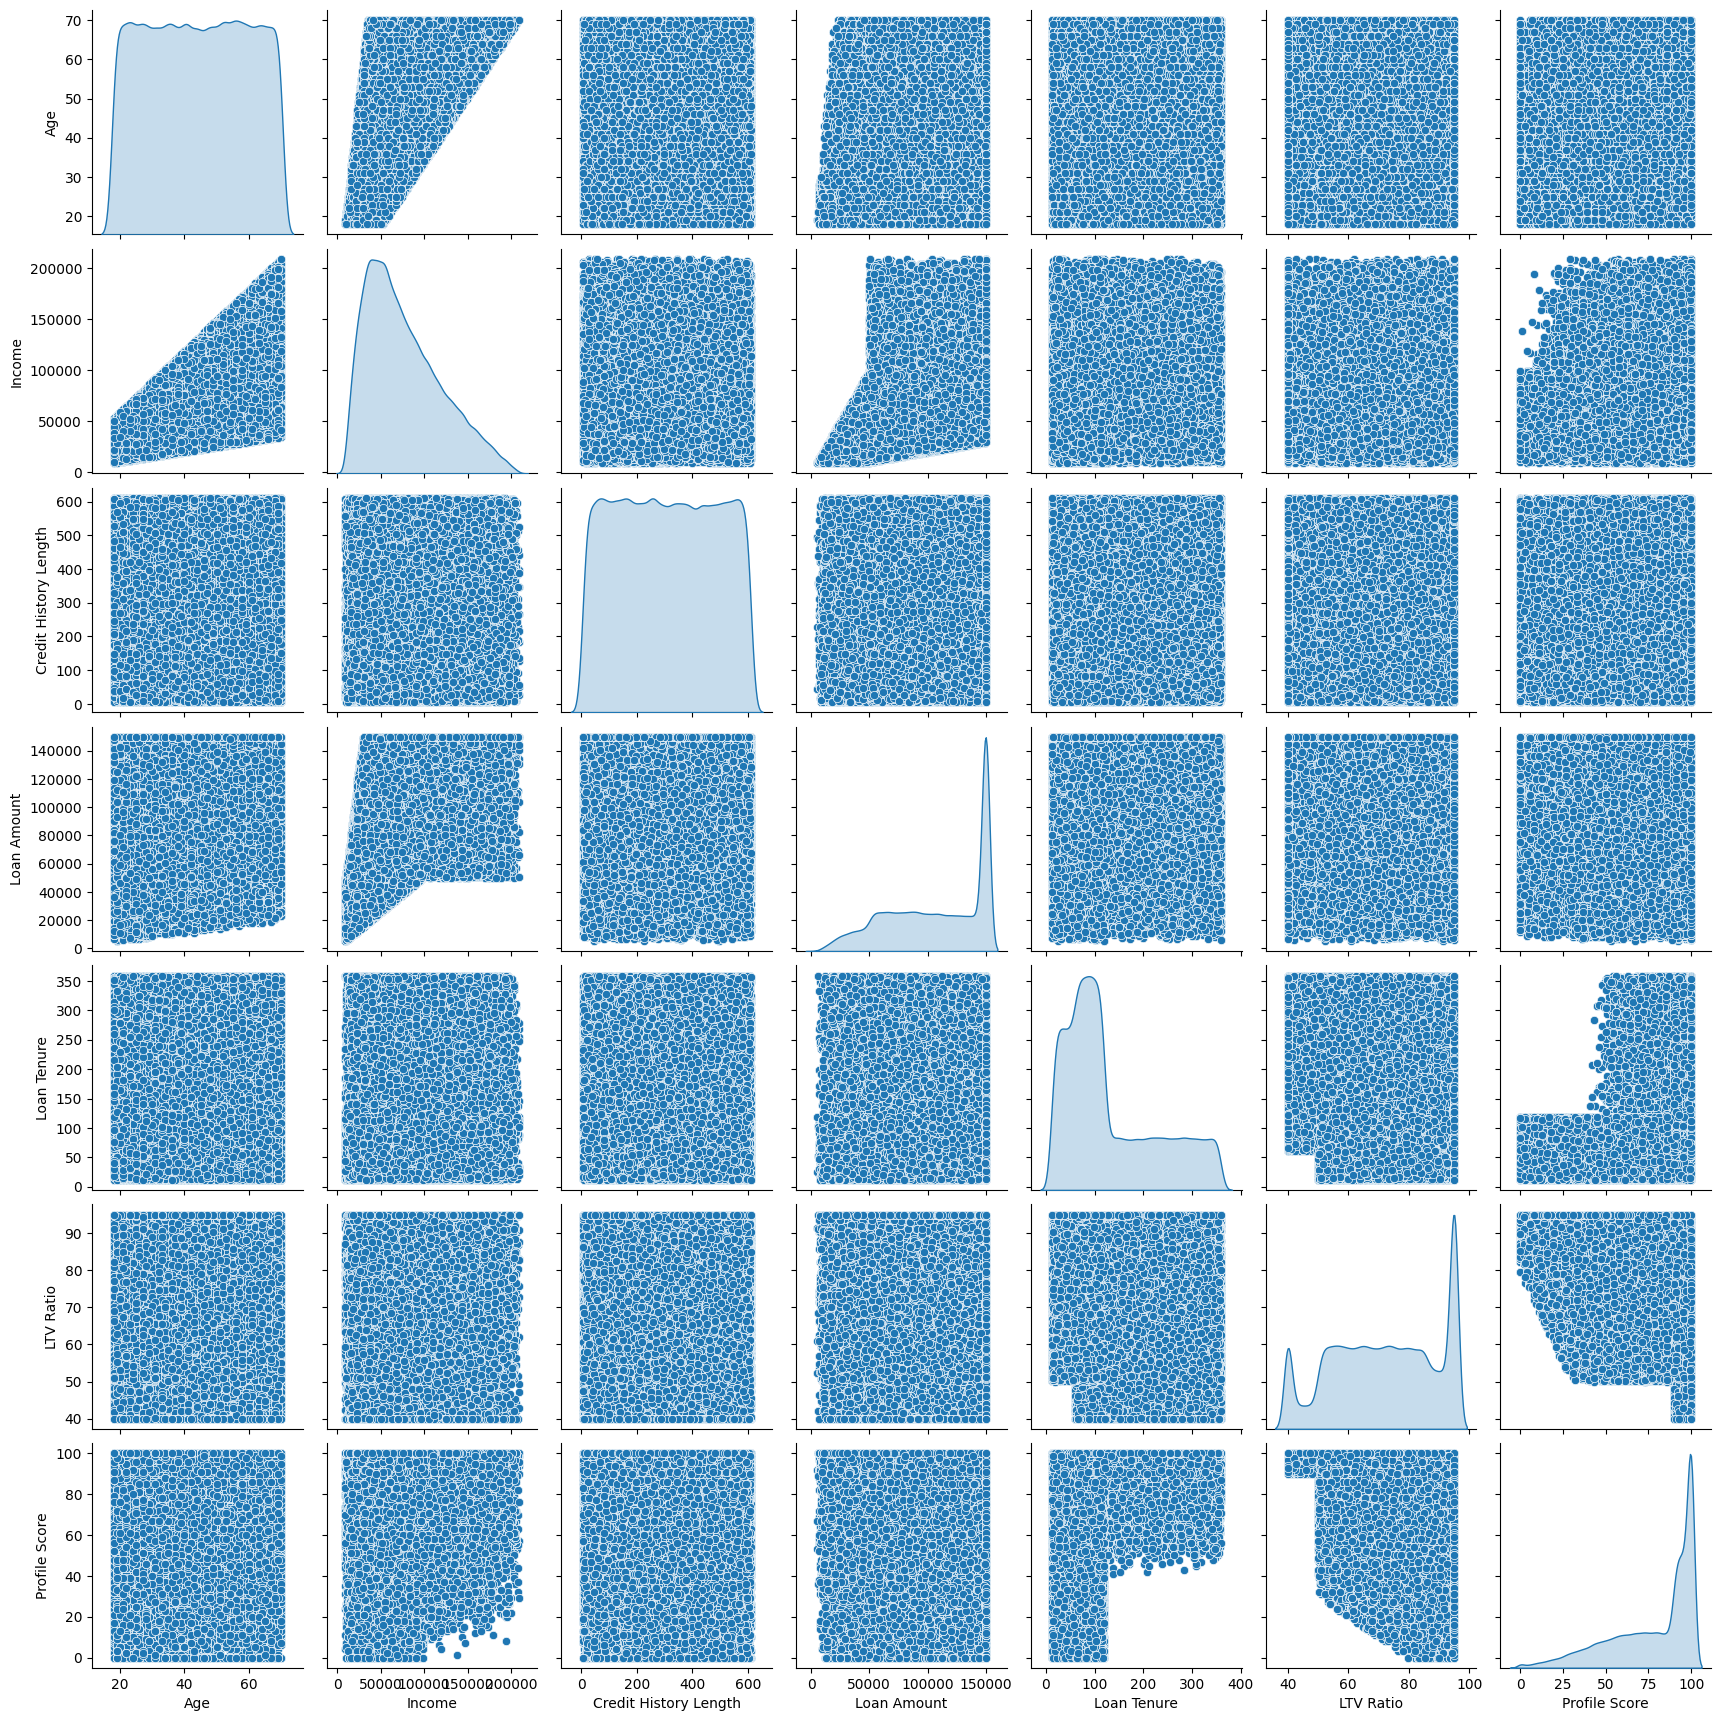

In [56]:
sns.pairplot(credit[numericas], diag_kind="kde")

- Correlacionan `Age` con `Income`.
- Podemos decir que también "se ve" entre `Income` y `Loan amount`.
- Dejamos `Income` y quitamos las otras dos.

#### Realizamos una regresión sin Age ni Loan amount

In [57]:
numericas_income = ['Income', 'Credit History Length', 'Loan Tenure', 'LTV Ratio', 'Profile Score']

In [58]:
# Plantemos una regresión en general con las numéricas
lin_reg = LinearRegression()
lin_reg.fit(X_train[numericas_income], y_train)

#Primero obtenemos las predicciones del modelo
y_pred = lin_reg.predict(X_test[numericas_income])

# Calculamos las métricas
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred)
mpe = mean_porcentual_error(y_test, y_pred)
print("R-cuadrado en test:", r2)
print("Error absoluto medio:", mae)
print("Error cuadratico medio:", mse)
print("Raiz de error cuadratico medio:", rmse)
print(f"Error absoluto porcentual medio: {mape*100:.2f}%")
print(f"Error porcentual medio: {mpe*100:.2f}%")

R-cuadrado en test: 0.6998533620140923
Error absoluto medio: 72.30289647270534
Error cuadratico medio: 7958.492664611287
Raiz de error cuadratico medio: 89.21038428687149
Error absoluto porcentual medio: 13.48%
Error porcentual medio: -2.50%


- No se ve una mejora de esta manera.
- Probamos ahora con las columnas categóricas.

#### Tenemos que convertir las categóricas en variables dummy

In [59]:
X_dummies = pd.get_dummies(data=X, columns=categoricas)
X_dummies.head()

,Age,Income,Credit History Length,Loan Amount,Loan Tenure,LTV Ratio,Profile Score,Gender_Female,Gender_Male,Gender_Other,...,Occupation_Farmer,Occupation_Graphic Designer,Occupation_Independent Consultant,Occupation_Other,Occupation_Photographer,Occupation_Shopkeeper,Occupation_Software Engineer,Occupation_Student,Occupation_Teacher,Occupation_Writer
0,31,36000,487,109373,221,90.943430,77,False,True,False,...,False,False,False,False,False,False,False,False,False,False
1,25,50000,386,150000,89,91.135253,43,False,True,False,...,False,False,False,False,False,False,True,False,False,False
2,62,178000,503,69099,110,40.000000,90,False,False,True,...,False,False,False,False,False,False,False,False,False,False
3,69,46000,349,150000,148,87.393365,86,True,False,False,...,False,False,False,False,False,False,False,False,False,False
4,52,132000,553,150000,157,66.158757,90,False,True,False,...,False,False,False,False,False,False,False,False,True,False


In [60]:
# Vemos las columnas para quitar la última de cada feature dummy
X_dummies.columns

Index(['Age', 'Income', 'Credit History Length', 'Loan Amount', 'Loan Tenure',
       'LTV Ratio', 'Profile Score', 'Gender_Female', 'Gender_Male',
       'Gender_Other', 'Existing Customer_No', 'Existing Customer_Yes',
       'Number of Existing Loans_0', 'Number of Existing Loans_1',
       'Number of Existing Loans_2', 'Number of Existing Loans_3',
       'Number of Existing Loans_4', 'Number of Existing Loans_5',
       'Number of Existing Loans_6', 'Number of Existing Loans_7',
       'Number of Existing Loans_8', 'Number of Existing Loans_9',
       'Number of Existing Loans_10', 'State_Delhi', 'State_Gujarat',
       'State_Karnataka', 'State_Kerala', 'State_Maharashtra',
       'State_Rajasthan', 'State_Tamil Nadu', 'State_Telangana',
       'State_Uttar Pradesh', 'State_West Bengal', 'City_Ahmedabad',
       'City_Bengaluru', 'City_Bishanpura', 'City_Channarayapatna',
       'City_Chennai', 'City_Coimbatore', 'City_Dhulagori', 'City_Hyderabad',
       'City_Jaipur', 'City_Kanp

In [61]:
# Quitamos la última de cada feature dummy
X_dummies = X_dummies.drop(columns=['Existing Customer_Yes','Number of Existing Loans_10','State_West Bengal','City_Udaipur','Employment Profile_Unemployed','Occupation_Writer'])

In [62]:
# Planteamos el split
# Separando nuestro dataset en entrenamiento y testeo
X_train, X_test, y_train, y_test = train_test_split(X_dummies, y, test_size=test_split, random_state=seed)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((195899, 70), (83957, 70), (195899,), (83957,))

In [63]:
# Plantemos una regresión en general con todas estas columnas
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [64]:
#Primero obtenemos las predicciones del modelo
y_pred = lin_reg.predict(X_test)

# Calculamos las métricas
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred)
mpe = mean_porcentual_error(y_test, y_pred)
print("R-cuadrado en test:", r2)
print("Error absoluto medio:", mae)
print("Error cuadratico medio:", mse)
print("Raiz de error cuadratico medio:", rmse)
print(f"Error absoluto porcentual medio: {mape*100:.2f}%")
print(f"Error porcentual medio: {mpe*100:.2f}%")

R-cuadrado en test: 0.9917245323202712
Error absoluto medio: 12.31807542095952
Error cuadratico medio: 219.42690835151504
Raiz de error cuadratico medio: 14.81306546098798
Error absoluto porcentual medio: 2.38%
Error porcentual medio: -0.09%


- Utilizando todas las columnas (quitando obviamente las correlacionadas) mejora considerablemente el modelo en todos los scores.
- Entonces decimos que las categóricas tienen gran impacto en la variable target.

#### Con todas las columnas, vemos de sacar algunas variables que correlacionen entre sí

In [65]:
# El modelo de statsmodel necesita una entrada para el termino independiente.
# Para ello vamos a agregar una columna de 1 en la primera columna
X_statsmodels = np.append(arr = np.ones((X_dummies.shape[0],1)).astype(int), values = X_dummies, axis = 1)

# Nivel de significancia que vamos a usar
SL = 0.05

In [66]:
# PLanteamos la regresión para conocer lo p-values
regression_OLS = sm.OLS(endog = y, exog = X_statsmodels.tolist()).fit()
regression_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Credit Score   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                 5.196e+05
Date:                Mon, 16 Oct 2023   Prob (F-statistic):               0.00
Time:                        16:34:41   Log-Likelihood:            -1.1509e+06
No. Observations:              279856   AIC:                         2.302e+06
Df Residuals:                  279790   BIC:                         2.303e+06
Df Model:                          65                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        525.5457      0.330   1593.924      0.000     524.899     526.192
x1             0.0026      0.002      1.117      0.264      -0.002       0.007
x2          1.541e-05      9e-07     17.124      0.000    1.36e-05    1.72e-05
x3          3.868e-05      0.000      0.242      0.809      -0.000       0.000
x4         -6.816e-07    7.5e-07     -0.909      0.364   -2.15e-06    7.89e-07
x5             0.0212      0.000     51.246      0.000       0.020       0.022
x6             0.0394      0.002     17.108      0.000       0.035       0.044
x7             0.1613      0.002     65.277      0.000       0.156       0.166
x8           175.1705      0.119   1475.681      0.000     174.938     175.403
x9           175.1883      0.119   1475.997      0.000     174.956     175.421
x10          175.1869      0.144   1217.932      0.000     174.905     175.469
x11          -27.0519      0.181   -149.303      0.000     -27.407     -26.697
x12         -494.7318      0.271  -1822.561      0.000    -495.264    -494.200
x13         -427.7068      0.260  -1646.090      0.000    -428.216    -427.198
x14         -377.2391      0.251  -1502.130      0.000    -377.731    -376.747
x15         -323.8747      0.247  -1312.108      0.000    -324.358    -323.391
x16         -270.0398      0.245  -1102.632      0.000    -270.520    -269.560
x17         -217.6955      0.239   -911.405      0.000    -218.164    -217.227
x18         -181.8632      0.170  -1072.823      0.000    -182.195    -181.531
x19         -137.3422      0.150   -914.580      0.000    -137.637    -137.048
x20          -82.4815      0.149   -551.882      0.000     -82.774     -82.189
x21          -32.8496      0.164   -200.824      0.000     -33.170     -32.529
x22           -0.6715      0.325     -2.063      0.039      -1.309      -0.034
x23            0.9000      0.324      2.778      0.005       0.265       1.535
x24           -0.8121      0.323     -2.516      0.012      -1.445      -0.179
x25           -0.6377      0.322     -1.981      0.048      -1.268      -0.007
x26            0.3238      0.324      1.001      0.317      -0.310       0.958
x27           -1.3114      0.326     -4.022      0.000      -1.950      -0.672
x28           -0.3617      0.321     -1.125      0.260      -0.992       0.268
x29           -0.0718      0.320     -0.224      0.823      -0.700       0.556
x30           -1.6091      0.327     -4.921      0.000      -2.250      -0.968
x31           -2.4906      0.377     -6.599      0.000      -3.230      -1.751
x32           -0.9052      0.377     -2.403      0.016      -1.644      -0.167
x33           -0.4250      0.305     -1.393      0.163      -1.023       0.173
x34           -0.3877      0.305     -1.272      0.203      -0.985       0.210
x35           -1.0996      0.375     -2.928      0.003      -1.836      -0.364
x3

- Eliminamos todas las variables que tienen el p-value mucho mayor que el nivel de significancia.

In [67]:
# Eliminamos X3, X29 y X40
X_opt = X_statsmodels[:,[0,1,2,4,5,6,7,8,9,10,
                        11,12,13,14,15,16,17,18,19,20,
                        21,22,23,24,25,26,27,28,30,31,
                        32,33,34,35,36,37,38,38,41,42,
                        43,44,45,46,47,48,49,50,51,52,
                        53,54,55,56,57,58,59,60,61,62,
                        63,64,65,66,67,68,69,70]]
regression_OLS = sm.OLS(endog = y, exog = X_opt.tolist()).fit()
regression_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Credit Score   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                 5.537e+05
Date:                Mon, 16 Oct 2023   Prob (F-statistic):               0.00
Time:                        16:34:44   Log-Likelihood:            -1.1509e+06
No. Observations:              279856   AIC:                         2.302e+06
Df Residuals:                  279794   BIC:                         2.302e+06
Df Model:                          61                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        525.5125      0.286   1839.580      0.000     524.953     526.072
x1             0.0026      0.002      1.116      0.264      -0.002       0.007
x2          1.541e-05      9e-07     17.122      0.000    1.36e-05    1.72e-05
x3         -6.811e-07    7.5e-07     -0.908      0.364   -2.15e-06    7.89e-07
x4             0.0212      0.000     51.248      0.000       0.020       0.022
x5             0.0394      0.002     17.107      0.000       0.035       0.044
x6             0.1613      0.002     65.278      0.000       0.156       0.166
x7           175.1595      0.105   1664.511      0.000     174.953     175.366
x8           175.1772      0.105   1664.618      0.000     174.971     175.383
x9           175.1759      0.133   1317.288      0.000     174.915     175.437
x10          -27.0521      0.181   -149.309      0.000     -27.407     -26.697
x11         -494.7320      0.271  -1822.616      0.000    -495.264    -494.200
x12         -427.7070      0.260  -1646.117      0.000    -428.216    -427.198
x13         -377.2395      0.251  -1502.165      0.000    -377.732    -376.747
x14         -323.8751      0.247  -1312.158      0.000    -324.359    -323.391
x15         -270.0403      0.245  -1102.663      0.000    -270.520    -269.560
x16         -217.6959      0.239   -911.425      0.000    -218.164    -217.228
x17         -181.8635      0.170  -1072.844      0.000    -182.196    -181.531
x18         -137.3425      0.150   -914.606      0.000    -137.637    -137.048
x19          -82.4818      0.149   -551.891      0.000     -82.775     -82.189
x20          -32.8498      0.164   -200.828      0.000     -33.170     -32.529
x21           -0.6348      0.281     -2.261      0.024      -1.185      -0.084
x22            0.9371      0.279      3.358      0.001       0.390       1.484
x23           -0.7754      0.278     -2.791      0.005      -1.320      -0.231
x24           -0.6006      0.277     -2.171      0.030      -1.143      -0.058
x25            0.3608      0.279      1.295      0.195      -0.185       0.907
x26           -1.2855      0.241     -5.337      0.000      -1.758      -0.813
x27           -0.3246      0.276     -1.175      0.240      -0.866       0.217
x28           -1.5615      0.241     -6.475      0.000      -2.034      -1.089
x29           -2.4624      0.323     -7.625      0.000      -3.095      -1.829
x30           -0.8768      0.322     -2.722      0.006      -1.508      -0.245
x31           -0.3972      0.234     -1.699      0.089      -0.855       0.061
x32           -0.3596      0.234     -1.537      0.124      -0.818       0.099
x33           -1.0714      0.321     -3.341      0.001      -1.700      -0.443
x34           -1.3242      0.320     -4.132      0.000      -1.952      -0.696
x35           -0.6578      0.233     -2.828      0.005      -1.114      -0.202
x3

- Todo el resto tiene un buen nivel de significancia.
- Planteamos entonces una regresión con estos features.
- Algo importante para recalcar, es que las variables categóricas tienen mucho significado para la regresión.

In [68]:
# Planteamos el split
# Separando nuestro dataset en entrenamiento y testeo
X_train, X_test, y_train, y_test = train_test_split(X_opt, y, test_size=test_split, random_state=seed)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((195899, 68), (83957, 68), (195899,), (83957,))

In [69]:
# Plantemos una regresión en general con todas estas columnas
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

#Primero obtenemos las predicciones del modelo
y_pred = lin_reg.predict(X_test)

# Calculamos las métricas
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred)
mpe = mean_porcentual_error(y_test, y_pred)
print("R-cuadrado en test:", r2)
print("Error absoluto medio:", mae)
print("Error cuadratico medio:", mse)
print("Raiz de error cuadratico medio:", rmse)
print(f"Error absoluto porcentual medio: {mape*100:.2f}%")
print(f"Error porcentual medio: {mpe*100:.2f}%")

R-cuadrado en test: 0.9917246689440378
Error absoluto medio: 12.318025016559988
Error cuadratico medio: 219.42328572475077
Raiz de error cuadratico medio: 14.812943182391228
Error absoluto porcentual medio: 2.38%
Error porcentual medio: -0.09%


- El resultado es idéntico a qué si tuvieramos todas las variables.
- Haber quitado estas variables, no generó una mejora notable.

#### Probamos solo con variables categóricas

In [70]:
# Vemos solamente las categóricas
X_only_cat = X_dummies.drop(columns=numericas)
X_only_cat.shape

(279856, 63)

In [71]:
# Planteamos el split
# Separando nuestro dataset en entrenamiento y testeo
X_train, X_test, y_train, y_test = train_test_split(X_only_cat, y, test_size=test_split, random_state=seed)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((195899, 63), (83957, 63), (195899,), (83957,))

In [72]:
# Plantemos una regresión en general con todas estas columnas
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

#Primero obtenemos las predicciones del modelo
y_pred = lin_reg.predict(X_test)

# Calculamos las métricas
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred)
mpe = mean_porcentual_error(y_test, y_pred)
print("R-cuadrado en test:", r2)
print("Error absoluto medio:", mae)
print("Error cuadratico medio:", mse)
print("Raiz de error cuadratico medio:", rmse)
print(f"Error absoluto porcentual medio: {mape*100:.2f}%")
print(f"Error porcentual medio: {mpe*100:.2f}%")

R-cuadrado en test: 0.9914781309446365
Error absoluto medio: 12.486197884873357
Error cuadratico medio: 225.96032666230295
Raiz de error cuadratico medio: 15.031976804875098
Error absoluto porcentual medio: 2.43%
Error porcentual medio: -0.09%


- Con solo categóricas, tenemos unos scores excelentes con este modelo.
- Podemos pensar que si usámos las máscaras planteadas para los features numéricos, este score podría mejorar.

#### Usando las variables enmascaradas

- Vamos a agregar las 4 máscaras planteadas anteriormente al dataset, y ver si mejora el modelo.

In [73]:
# Vemos cuáles son las variables categóricas actuales
X[categoricas].columns

Index(['Gender', 'Existing Customer', 'Number of Existing Loans', 'State',
       'City', 'Employment Profile', 'Occupation'],
      dtype='object')

In [74]:
X[categoricas].shape

(279856, 7)

In [75]:
X_mask = pd.DataFrame({
    'Mask Loan': mask_loan,
    'Mask Tenure': mask_tenure,
    'Mask LTV': mask_ltv,
    'Mask Profile': mask_profile
})
X_mask.head()

,Mask Loan,Mask Tenure,Mask LTV,Mask Profile
0,0,0,1,0
1,1,1,1,0
2,0,1,0,1
3,1,0,1,0
4,1,0,0,1


In [76]:
# Agregamos al data frame de categóricas estas variables
X_new_cat = pd.concat([X[categoricas], X_mask], axis=1)
X_new_cat.columns

Index(['Gender', 'Existing Customer', 'Number of Existing Loans', 'State',
       'City', 'Employment Profile', 'Occupation', 'Mask Loan', 'Mask Tenure',
       'Mask LTV', 'Mask Profile'],
      dtype='object')

In [77]:
# Convertimos las variables string en dummies
X_new_cat_dummies = pd.get_dummies(X_new_cat, columns=categoricas)
X_new_cat_dummies.columns

Index(['Mask Loan', 'Mask Tenure', 'Mask LTV', 'Mask Profile', 'Gender_Female',
       'Gender_Male', 'Gender_Other', 'Existing Customer_No',
       'Existing Customer_Yes', 'Number of Existing Loans_0',
       'Number of Existing Loans_1', 'Number of Existing Loans_2',
       'Number of Existing Loans_3', 'Number of Existing Loans_4',
       'Number of Existing Loans_5', 'Number of Existing Loans_6',
       'Number of Existing Loans_7', 'Number of Existing Loans_8',
       'Number of Existing Loans_9', 'Number of Existing Loans_10',
       'State_Delhi', 'State_Gujarat', 'State_Karnataka', 'State_Kerala',
       'State_Maharashtra', 'State_Rajasthan', 'State_Tamil Nadu',
       'State_Telangana', 'State_Uttar Pradesh', 'State_West Bengal',
       'City_Ahmedabad', 'City_Bengaluru', 'City_Bishanpura',
       'City_Channarayapatna', 'City_Chennai', 'City_Coimbatore',
       'City_Dhulagori', 'City_Hyderabad', 'City_Jaipur', 'City_Kanpur',
       'City_Kochi', 'City_Kolkata', 'City_Luckn

In [78]:
# Eliminamos las correlacionales de cada feature
X_new_cat_dummies = X_new_cat_dummies.drop(columns=['Existing Customer_Yes','Number of Existing Loans_10','State_West Bengal',
                                                    'City_Udaipur','Employment Profile_Unemployed','Occupation_Writer'])
X_new_cat_dummies.columns

Index(['Mask Loan', 'Mask Tenure', 'Mask LTV', 'Mask Profile', 'Gender_Female',
       'Gender_Male', 'Gender_Other', 'Existing Customer_No',
       'Number of Existing Loans_0', 'Number of Existing Loans_1',
       'Number of Existing Loans_2', 'Number of Existing Loans_3',
       'Number of Existing Loans_4', 'Number of Existing Loans_5',
       'Number of Existing Loans_6', 'Number of Existing Loans_7',
       'Number of Existing Loans_8', 'Number of Existing Loans_9',
       'State_Delhi', 'State_Gujarat', 'State_Karnataka', 'State_Kerala',
       'State_Maharashtra', 'State_Rajasthan', 'State_Tamil Nadu',
       'State_Telangana', 'State_Uttar Pradesh', 'City_Ahmedabad',
       'City_Bengaluru', 'City_Bishanpura', 'City_Channarayapatna',
       'City_Chennai', 'City_Coimbatore', 'City_Dhulagori', 'City_Hyderabad',
       'City_Jaipur', 'City_Kanpur', 'City_Kochi', 'City_Kolkata',
       'City_Lucknow', 'City_Manjari', 'City_Mumbai', 'City_Mysuru',
       'City_Nagpur', 'City_Nelli

- Luego de hacer esto, pasamos a plantear la regresión.

In [79]:
# Realizamos un análisis de regresión con estas columnas
# Planteamos el split
# Separando nuestro dataset en entrenamiento y testeo
X_train, X_test, y_train, y_test = train_test_split(X_new_cat_dummies, y, test_size=test_split, random_state=seed)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((195899, 67), (83957, 67), (195899,), (83957,))

In [80]:
# Plantemos una regresión en general con todas estas columnas
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

#Primero obtenemos las predicciones del modelo
y_pred = lin_reg.predict(X_test)

# Calculamos las métricas
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred)
mpe = mean_porcentual_error(y_test, y_pred)
print("R-cuadrado en test:", r2)
print("Error absoluto medio:", mae)
print("Error cuadratico medio:", mse)
print("Raiz de error cuadratico medio:", rmse)
print(f"Error absoluto porcentual medio: {mape*100:.2f}%")
print(f"Error porcentual medio: {mpe*100:.2f}%")

R-cuadrado en test: 0.9916566650124151
Error absoluto medio: 12.383142121976316
Error cuadratico medio: 221.22643366142344
Raiz de error cuadratico medio: 14.873682585742626
Error absoluto porcentual medio: 2.40%
Error porcentual medio: -0.09%


- Existe una mejora en todos los scores, con respecto a realizarlo con solo las categóricas.
- Si bien no es una sustancial mejora, tiene impacto positivo agregar estas columnas enmascaradas.

### Polynomial features
- Planteamos con solamente las numéricas si mejoran los scores

In [81]:
# Planteamos de grado 2
pol_reg = PolynomialFeatures(degree = 2)

# Planteamos el split
# Separando nuestro dataset en entrenamiento y testeo
X_train, X_test, y_train, y_test = train_test_split(X[numericas], y, test_size=test_split, random_state=seed)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((195899, 7), (83957, 7), (195899,), (83957,))

In [82]:
# Basicamente nos crea un array con los terminos lineal y cuadraticos
X_poly = pol_reg.fit_transform(X_train)
lin_reg_2 = LinearRegression()
lin_reg_2.fit(X_poly, y_train)

LinearRegression()

In [83]:
# Plantemos una regresión en general con todas estas columnas
lin_reg_2 = LinearRegression()
lin_reg_2.fit(X_train, y_train)

#Primero obtenemos las predicciones del modelo
y_pred = lin_reg_2.predict(X_test)

# Calculamos las métricas
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred)
mpe = mean_porcentual_error(y_test, y_pred)
print("R-cuadrado en test:", r2)
print("Error absoluto medio:", mae)
print("Error cuadratico medio:", mse)
print("Raiz de error cuadratico medio:", rmse)
print(f"Error absoluto porcentual medio: {mape*100:.2f}%")
print(f"Error porcentual medio: {mpe*100:.2f}%")

R-cuadrado en test: 0.6998765464962519
Error absoluto medio: 72.3002707472584
Error cuadratico medio: 7957.877919990331
Raiz de error cuadratico medio: 89.20693874352114
Error absoluto porcentual medio: 13.47%
Error porcentual medio: -2.50%


- No hay una mejora significativa contra el numérico solamante y aumenta el número de features, así que podemos decir que no debería usarse.

## Clasificación
- Para plantear clasificación, utilizamos la máscara propuesta del 75% del rango de `Credit Score`.
- Planteamos binaria con clases equilibradas.

In [84]:
# Calculamos el 75% del rango
rango = max(credit['Credit Score']) - min(credit['Credit Score'])
umbral = 0.75*rango + min(credit['Credit Score'])
umbral

712.5

In [85]:
# Definimos la variable score como la máscara ante el valor medio de score. De esta manera, exigimos a la clase target que esté balanceada
score = credit['Credit Score'].copy()
mask_score_value = umbral
score = score.apply(lambda x: 1 if x>=mask_score_value else 0)
score.value_counts() / len(credit)

Credit Score
0    0.732266
1    0.267734
Name: count, dtype: float64

- Planteamos para este escenario, el split general y luego analizamos qué nos conviene en pos de los features por modelo.

In [86]:
# Definimos quienes serán la X y la y
X = credit.drop('Credit Score', axis=1)
y = score

### Regresión Logística

#### Plantemos primero solo con features numéricas

In [87]:
# Planteamos el split
# Separando nuestro dataset en entrenamiento y testeo
X_train, X_test, y_train, y_test = train_test_split(X[numericas], y, test_size=test_split, random_state=seed)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((195899, 7), (83957, 7), (195899,), (83957,))

In [88]:
# Vamos a revisar el equilibrio de clases que tiene cada split
print(f"Contamos los labels de train:\n{y_train.value_counts()/len(y_train)}")
print(f"Contamos los labels de test: \n{y_test.value_counts()/len(y_test)}")

Contamos los labels de train:
Credit Score
0    0.732311
1    0.267689
Name: count, dtype: float64
Contamos los labels de test: 
Credit Score
0    0.732161
1    0.267839
Name: count, dtype: float64


In [89]:
# Vamos a usar regresión logística porque se quiere predecir si es una clase 0 o 1
log_reg = LogisticRegression(solver='newton-cholesky')
log_reg.fit(X_train, y_train)

LogisticRegression(solver='newton-cholesky')

La matriz de confusión: 
 [[54580  6890]
 [ 6996 15491]]


Reporte de clasificación: 
               precision    recall  f1-score   support

           0       0.89      0.89      0.89     61470
           1       0.69      0.69      0.69     22487

    accuracy                           0.83     83957
   macro avg       0.79      0.79      0.79     83957
weighted avg       0.83      0.83      0.83     83957

Modelo con todos los atributos AUC: 0.9130314267436148


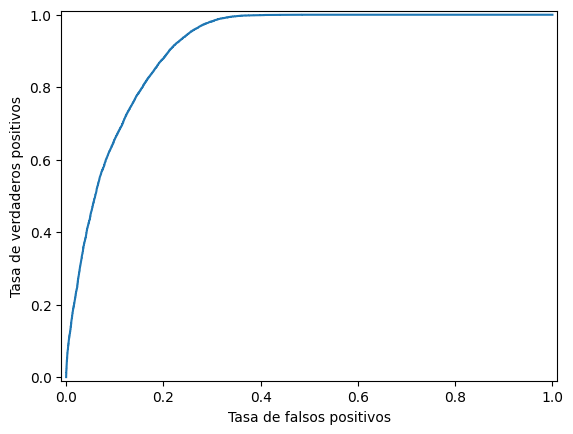

In [90]:
# Predecimos los valores
y_hat = log_reg.predict(X_test)

# Calculamos la matriz de confusión
cm = confusion_matrix(y_test, y_hat)
print("La matriz de confusión: \n", cm)
print("\n")

# Calculamos el reporte de clasificación
cr = classification_report(y_test, y_hat)
print("Reporte de clasificación: \n", cr)

# Calculamos la probabilidad del modelo
prob_total = log_reg.predict_proba(X_test)[:, -1] # para llevarlo a 1-d

# Realizamos la curva roc
fpr_total, tpr_total, _ = roc_curve(y_true=y_test, y_score=prob_total)

# Ploteamos la curva
plt.plot(fpr_total, tpr_total, label="Modelo con todos los atributos numéricos")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel("Tasa de falsos positivos")
plt.ylabel("Tasa de verdaderos positivos")

# Calculamos el auc
print(f"Modelo con todos los atributos AUC: {auc(fpr_total, tpr_total)}")

- Vemos que tiene unos muy buenos valores de score de esta manera.
- Vemos si mejora con los dummies sin los que correlacionan.

#### Con todas las features

In [91]:
# Planteamos el split
# Separando nuestro dataset en entrenamiento y testeo
X_train, X_test, y_train, y_test = train_test_split(X_dummies, y, test_size=test_split, random_state=seed)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((195899, 70), (83957, 70), (195899,), (83957,))

In [92]:
# Vamos a usar regresión logística porque se quiere predecir si es una clase 0 o 1
log_reg = LogisticRegression(solver='newton-cholesky') # usamos un modelo con este solver ya que el n_samples >> n_features
log_reg.fit(X_train, y_train)

LogisticRegression(solver='newton-cholesky')

La matriz de confusión: 
 [[59707  1763]
 [ 1478 21009]]


Reporte de clasificación: 
               precision    recall  f1-score   support

           0       0.98      0.97      0.97     61470
           1       0.92      0.93      0.93     22487

    accuracy                           0.96     83957
   macro avg       0.95      0.95      0.95     83957
weighted avg       0.96      0.96      0.96     83957

Modelo con todos los atributos AUC: 0.9957950760466495


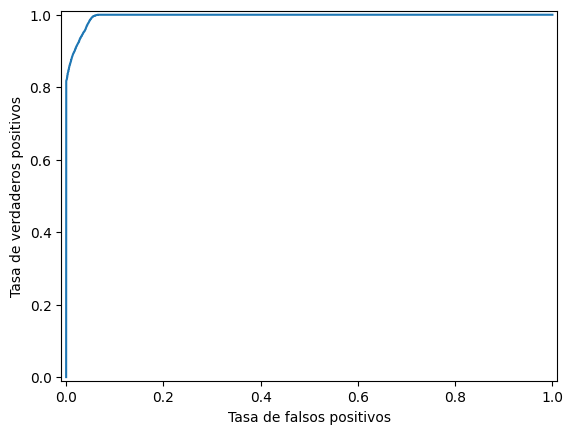

In [93]:
# Predecimos los valores
y_hat = log_reg.predict(X_test)

# Calculamos la matriz de confusión
cm = confusion_matrix(y_test, y_hat)
print("La matriz de confusión: \n", cm)
print("\n")

# Calculamos el reporte de clasificación
cr = classification_report(y_test, y_hat)
print("Reporte de clasificación: \n", cr)

# Calculamos la probabilidad del modelo
prob_total = log_reg.predict_proba(X_test)[:, -1] # para llevarlo a 1-d

# Realizamos la curva roc
fpr_total, tpr_total, _ = roc_curve(y_true=y_test, y_score=prob_total)

# Ploteamos la curva
plt.plot(fpr_total, tpr_total, label="Modelo con todos los atributos")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel("Tasa de falsos positivos")
plt.ylabel("Tasa de verdaderos positivos")

# Calculamos el auc
print(f"Modelo con todos los atributos AUC: {auc(fpr_total, tpr_total)}")

- Como era esperable, tenemos una mejora notable en los scores.
- Plantemos solamente con los categóricos.

#### Con solo categóricas

In [94]:
# Planteamos el split
# Separando nuestro dataset en entrenamiento y testeo
X_train, X_test, y_train, y_test = train_test_split(X_only_cat, y, test_size=test_split, random_state=seed)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((195899, 63), (83957, 63), (195899,), (83957,))

In [95]:
# Vamos a usar regresión logística porque se quiere predecir si es una clase 0 o 1
log_reg = LogisticRegression(solver='newton-cholesky') # usamos un modelo con este solver ya que el n_samples >> n_features
log_reg.fit(X_train, y_train)

LogisticRegression(solver='newton-cholesky')

La matriz de confusión: 
 [[59687  1783]
 [ 2210 20277]]


Reporte de clasificación: 
               precision    recall  f1-score   support

           0       0.96      0.97      0.97     61470
           1       0.92      0.90      0.91     22487

    accuracy                           0.95     83957
   macro avg       0.94      0.94      0.94     83957
weighted avg       0.95      0.95      0.95     83957

Modelo con todos los atributos AUC: 0.9940065242691891


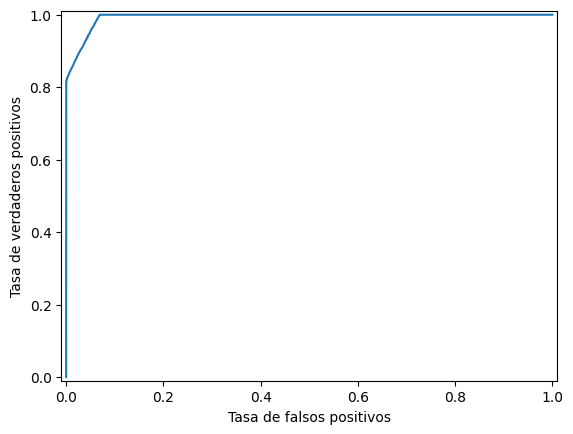

In [96]:
# Predecimos los valores
y_hat = log_reg.predict(X_test)

# Calculamos la matriz de confusión
cm = confusion_matrix(y_test, y_hat)
print("La matriz de confusión: \n", cm)
print("\n")

# Calculamos el reporte de clasificación
cr = classification_report(y_test, y_hat)
print("Reporte de clasificación: \n", cr)

# Calculamos la probabilidad del modelo
prob_total = log_reg.predict_proba(X_test)[:, -1] # para llevarlo a 1-d

# Realizamos la curva roc
fpr_total, tpr_total, _ = roc_curve(y_true=y_test, y_score=prob_total)

# Ploteamos la curva
plt.plot(fpr_total, tpr_total, label="Modelo con solo los atributos categóricos")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel("Tasa de falsos positivos")
plt.ylabel("Tasa de verdaderos positivos")

# Calculamos el auc
print(f"Modelo con todos los atributos AUC: {auc(fpr_total, tpr_total)}")

- Hasta el momento, tiene mejores scores el modelo con todas las features para clasificación.

### Clasificador KNN

- Planteamos un clasificador KNN con las variables numéricas primero.

In [97]:
# Planteamos el split
# Separando nuestro dataset en entrenamiento y testeo
X_train, X_test, y_train, y_test = train_test_split(X[numericas], y, test_size=test_split, random_state=seed)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((195899, 7), (83957, 7), (195899,), (83957,))

In [98]:
# Planteamos un clasificador con 5 neighbors
classifier_knn = KNeighborsClassifier(n_neighbors=5, metric="minkowski", p=2)
classifier_knn.fit(X_train, y_train)

KNeighborsClassifier()

La matriz de confusión: 
 [[53519  7951]
 [11569 10918]]


Reporte de clasificación: 
               precision    recall  f1-score   support

           0       0.82      0.87      0.85     61470
           1       0.58      0.49      0.53     22487

    accuracy                           0.77     83957
   macro avg       0.70      0.68      0.69     83957
weighted avg       0.76      0.77      0.76     83957

Modelo con todos los atributos AUC: 0.8354802980033168


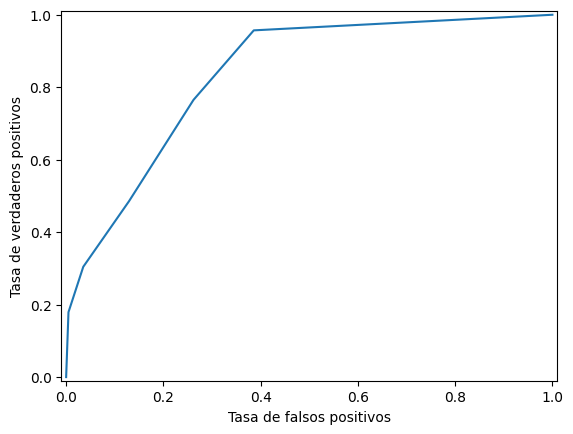

In [99]:
# Predecimos los valores
y_hat = classifier_knn.predict(X_test)

# Calculamos la matriz de confusión
cm = confusion_matrix(y_test, y_hat)
print("La matriz de confusión: \n", cm)
print("\n")

# Calculamos el reporte de clasificación
cr = classification_report(y_test, y_hat)
print("Reporte de clasificación: \n", cr)

# Calculamos la probabilidad del modelo
prob_total = classifier_knn.predict_proba(X_test)[:, -1] # para llevarlo a 1-d

# Realizamos la curva roc
fpr_total, tpr_total, _ = roc_curve(y_true=y_test, y_score=prob_total)

# Ploteamos la curva
plt.plot(fpr_total, tpr_total, label="Modelo con todos los atributos numéricos")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel("Tasa de falsos positivos")
plt.ylabel("Tasa de verdaderos positivos")

# Calculamos el auc
print(f"Modelo con todos los atributos AUC: {auc(fpr_total, tpr_total)}")

- No es tan buen clasificador. Probamos con más vecinos.

In [100]:
# Planteamos un clasificador con 9 neighbors
classifier_knn = KNeighborsClassifier(n_neighbors=9, metric="minkowski", p=2)
classifier_knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=9)

La matriz de confusión: 
 [[54933  6537]
 [13362  9125]]


Reporte de clasificación: 
               precision    recall  f1-score   support

           0       0.80      0.89      0.85     61470
           1       0.58      0.41      0.48     22487

    accuracy                           0.76     83957
   macro avg       0.69      0.65      0.66     83957
weighted avg       0.74      0.76      0.75     83957

Modelo con todos los atributos AUC: 0.7853325981110759


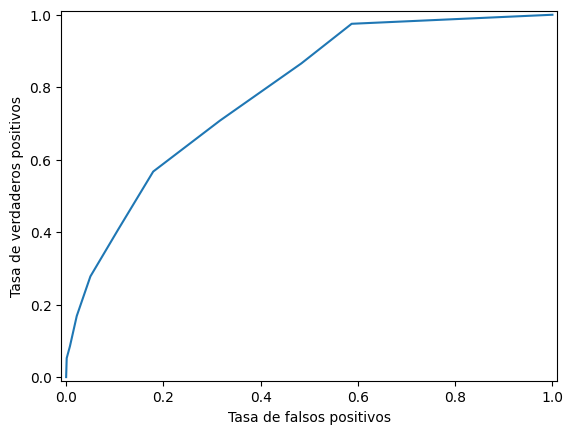

In [101]:
# Predecimos los valores
y_hat = classifier_knn.predict(X_test)

# Calculamos la matriz de confusión
cm = confusion_matrix(y_test, y_hat)
print("La matriz de confusión: \n", cm)
print("\n")

# Calculamos el reporte de clasificación
cr = classification_report(y_test, y_hat)
print("Reporte de clasificación: \n", cr)

# Calculamos la probabilidad del modelo
prob_total = classifier_knn.predict_proba(X_test)[:, -1] # para llevarlo a 1-d

# Realizamos la curva roc
fpr_total, tpr_total, _ = roc_curve(y_true=y_test, y_score=prob_total)

# Ploteamos la curva
plt.plot(fpr_total, tpr_total, label="Modelo con todos los atributos numéricos")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel("Tasa de falsos positivos")
plt.ylabel("Tasa de verdaderos positivos")

# Calculamos el auc
print(f"Modelo con todos los atributos AUC: {auc(fpr_total, tpr_total)}")

In [102]:
# Planteamos un clasificador con 3 neighbors
classifier_knn = KNeighborsClassifier(n_neighbors=3, metric="minkowski", p=2)
classifier_knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

La matriz de confusión: 
 [[54879  6591]
 [ 7529 14958]]


Reporte de clasificación: 
               precision    recall  f1-score   support

           0       0.88      0.89      0.89     61470
           1       0.69      0.67      0.68     22487

    accuracy                           0.83     83957
   macro avg       0.79      0.78      0.78     83957
weighted avg       0.83      0.83      0.83     83957

Modelo con todos los atributos AUC: 0.8927079426958682


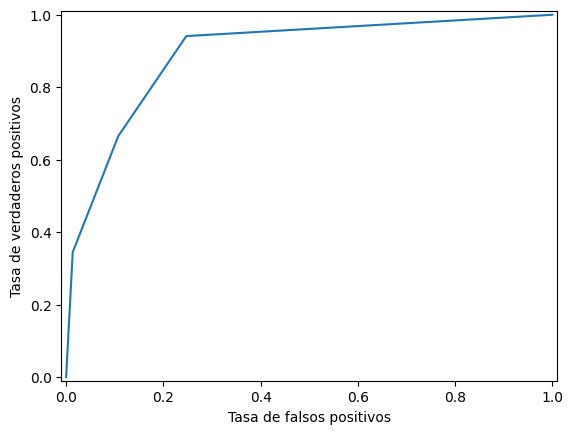

In [103]:
# Predecimos los valores
y_hat = classifier_knn.predict(X_test)

# Calculamos la matriz de confusión
cm = confusion_matrix(y_test, y_hat)
print("La matriz de confusión: \n", cm)
print("\n")

# Calculamos el reporte de clasificación
cr = classification_report(y_test, y_hat)
print("Reporte de clasificación: \n", cr)

# Calculamos la probabilidad del modelo
prob_total = classifier_knn.predict_proba(X_test)[:, -1] # para llevarlo a 1-d

# Realizamos la curva roc
fpr_total, tpr_total, _ = roc_curve(y_true=y_test, y_score=prob_total)

# Ploteamos la curva
plt.plot(fpr_total, tpr_total, label="Modelo con todos los atributos numéricos")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel("Tasa de falsos positivos")
plt.ylabel("Tasa de verdaderos positivos")

# Calculamos el auc
print(f"Modelo con todos los atributos AUC: {auc(fpr_total, tpr_total)}")

- Con 9 vecinos son más bajos los scores.
- Con 3 vecinos mejoran los scores.

#### Probamos extendiendo con las features categóricas

In [104]:
# Planteamos el split
# Separando nuestro dataset en entrenamiento y testeo
X_train, X_test, y_train, y_test = train_test_split(X_dummies, y, test_size=test_split, random_state=seed)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((195899, 70), (83957, 70), (195899,), (83957,))

In [105]:
# Planteamos un clasificador con 3 neighbors, que dió mejor con los features numéricos
classifier_knn = KNeighborsClassifier(n_neighbors=3, metric="minkowski", p=2)
classifier_knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

La matriz de confusión: 
 [[54882  6588]
 [ 7528 14959]]


Reporte de clasificación: 
               precision    recall  f1-score   support

           0       0.88      0.89      0.89     61470
           1       0.69      0.67      0.68     22487

    accuracy                           0.83     83957
   macro avg       0.79      0.78      0.78     83957
weighted avg       0.83      0.83      0.83     83957

Modelo con todos los atributos AUC: 0.8927492412531337


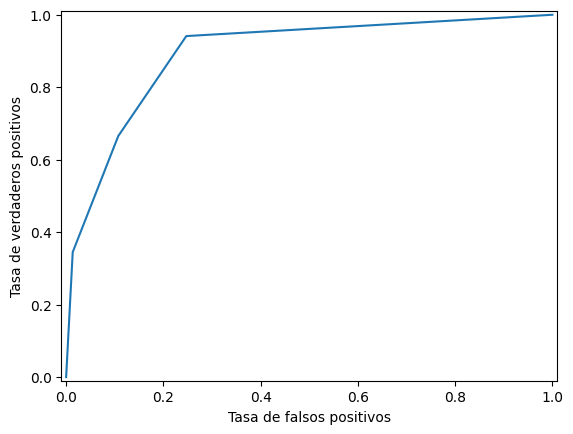

In [106]:
# Predecimos los valores
y_hat = classifier_knn.predict(X_test)

# Calculamos la matriz de confusión
cm = confusion_matrix(y_test, y_hat)
print("La matriz de confusión: \n", cm)
print("\n")

# Calculamos el reporte de clasificación
cr = classification_report(y_test, y_hat)
print("Reporte de clasificación: \n", cr)

# Calculamos la probabilidad del modelo
prob_total = classifier_knn.predict_proba(X_test)[:, -1] # para llevarlo a 1-d

# Realizamos la curva roc
fpr_total, tpr_total, _ = roc_curve(y_true=y_test, y_score=prob_total)

# Ploteamos la curva
plt.plot(fpr_total, tpr_total, label="Modelo con todos los atributos")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel("Tasa de falsos positivos")
plt.ylabel("Tasa de verdaderos positivos")

# Calculamos el auc
print(f"Modelo con todos los atributos AUC: {auc(fpr_total, tpr_total)}")

- Con feature categóricas, se vuelve muy lento para hacer el cálculo y no representa una mejora realmente.
- Se deja de lado como modelo a utilizar.

### Árboles de clasificación

- No es necesario realizar una separación de variables entre numéricas y categóricas.
- Se usará el dataset dummies.

In [107]:
# Planteamos el split
# Separando nuestro dataset en entrenamiento y testeo
X_train, X_test, y_train, y_test = train_test_split(X_dummies, y, test_size=test_split, random_state=seed)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((195899, 70), (83957, 70), (195899,), (83957,))

In [108]:
# Planteamos clasificador con entropía como criterio
tree = DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=seed)
tree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=17)

La matriz de confusión: 
 [[61245   225]
 [  232 22255]]


Reporte de clasificación: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     61470
           1       0.99      0.99      0.99     22487

    accuracy                           0.99     83957
   macro avg       0.99      0.99      0.99     83957
weighted avg       0.99      0.99      0.99     83957

Modelo con todos los atributos AUC: 0.9930113029027802


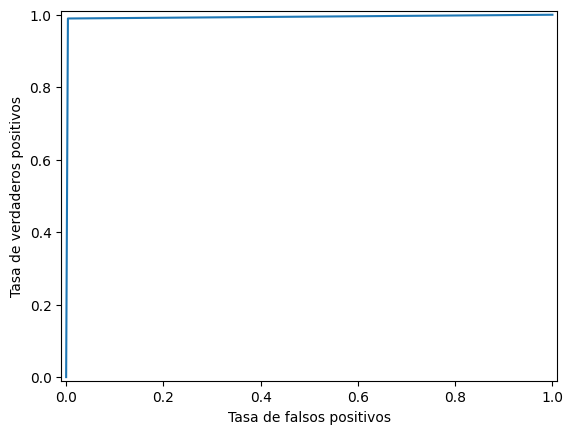

In [109]:
# Predecimos los valores
y_hat = tree.predict(X_test)

# Calculamos la matriz de confusión
cm = confusion_matrix(y_test, y_hat)
print("La matriz de confusión: \n", cm)
print("\n")

# Calculamos el reporte de clasificación
cr = classification_report(y_test, y_hat)
print("Reporte de clasificación: \n", cr)

# Calculamos la probabilidad del modelo
prob_total = tree.predict_proba(X_test)[:, -1] # para llevarlo a 1-d

# Realizamos la curva roc
fpr_total, tpr_total, _ = roc_curve(y_true=y_test, y_score=prob_total)

# Ploteamos la curva
plt.plot(fpr_total, tpr_total, label="Modelo con todos los atributos")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel("Tasa de falsos positivos")
plt.ylabel("Tasa de verdaderos positivos")

# Calculamos el auc
print(f"Modelo con todos los atributos AUC: {auc(fpr_total, tpr_total)}")

- El clasificador es casi perfecto. ¿Se puede desconfiar?
- Podemos plantear un proceso de poda y ver en menor profundidad si tenemos un buen score.

In [110]:
# Planteamos clasificador con Gini como criterio
tree = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=seed)
tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=17)

La matriz de confusión: 
 [[61246   224]
 [  257 22230]]


Reporte de clasificación: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     61470
           1       0.99      0.99      0.99     22487

    accuracy                           0.99     83957
   macro avg       0.99      0.99      0.99     83957
weighted avg       0.99      0.99      0.99     83957

Modelo con todos los atributos AUC: 0.9924635602231331


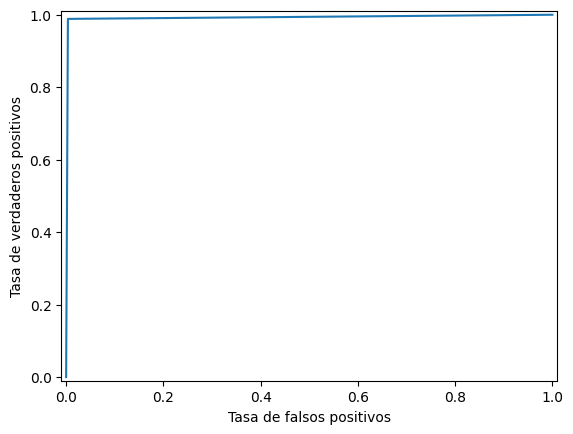

In [111]:
# Predecimos los valores
y_hat = tree.predict(X_test)

# Calculamos la matriz de confusión
cm = confusion_matrix(y_test, y_hat)
print("La matriz de confusión: \n", cm)
print("\n")

# Calculamos el reporte de clasificación
cr = classification_report(y_test, y_hat)
print("Reporte de clasificación: \n", cr)

# Calculamos la probabilidad del modelo
prob_total = tree.predict_proba(X_test)[:, -1] # para llevarlo a 1-d

# Realizamos la curva roc
fpr_total, tpr_total, _ = roc_curve(y_true=y_test, y_score=prob_total)

# Ploteamos la curva
plt.plot(fpr_total, tpr_total, label="Modelo con todos los atributos")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel("Tasa de falsos positivos")
plt.ylabel("Tasa de verdaderos positivos")

# Calculamos el auc
print(f"Modelo con todos los atributos AUC: {auc(fpr_total, tpr_total)}")

- Es a penas un poco mejor con criterio de Gini que con Entropy.
- Planteamos la poda del arbol.

#### Podamos el arbol

In [112]:
# Hagamos Cross-validation para varios valores de profundidad del arbol usando el criterio de Gini
scores_list = []
depth_array = np.arange(1, 10)
leaf_array = np.zeros_like(depth_array)
for index, depth in enumerate(depth_array):
    clf = DecisionTreeClassifier(criterion='gini', max_depth=depth)
    scores_list.append(np.abs(cross_val_score(clf, X_train, y_train, cv=10, scoring='f1')))
    clf.fit(X_train, y_train)

scores_array = np.array(scores_list)
del scores_list

df_results = pd.DataFrame({"depth": depth_array,
                           "f11": scores_array[:, 0],
                           "f12": scores_array[:, 1],
                           "f13": scores_array[:, 2],
                           "f14": scores_array[:, 3],
                           "f15": scores_array[:, 4]})

df_results = pd.melt(df_results, id_vars=['depth'], value_vars=["f11", "f12", "f13", "f14", "f15"])

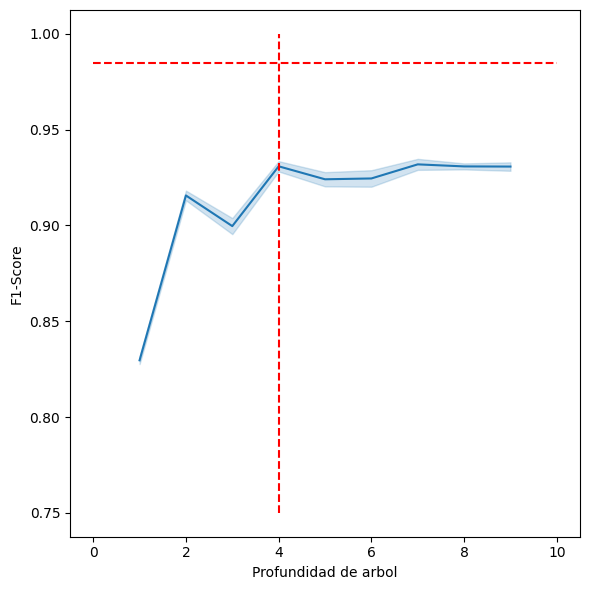

In [113]:
# Ploteamos el punto de corte
f, ax = plt.subplots(1,1, figsize=(6, 6))
sns.lineplot(data=df_results, x="depth", y="value", errorbar="sd", ax=ax)
ax.plot([4, 4], [0.75, 1], color="red", linestyle="--")
ax.plot([0, 10], [0.985, 0.985], color="red", linestyle="--")

ax.set_xlabel("Profundidad de arbol")
ax.set_ylabel("F1-Score")
plt.tight_layout()

- Se requiere de mucho tiempo para realizar este análisis.
- Podemos hacer un nuevo modelo con un nivel de profundidad 4 luego de estos resultados.

In [114]:
# Planteamos clasificador con Gini como criterio
tree = DecisionTreeClassifier(criterion='gini', max_depth=4, random_state=seed)
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=17)

La matriz de confusión: 
 [[58017  3453]
 [    1 22486]]


Reporte de clasificación: 
               precision    recall  f1-score   support

           0       1.00      0.94      0.97     61470
           1       0.87      1.00      0.93     22487

    accuracy                           0.96     83957
   macro avg       0.93      0.97      0.95     83957
weighted avg       0.96      0.96      0.96     83957

Modelo con todos los atributos AUC: 0.9948224937931891


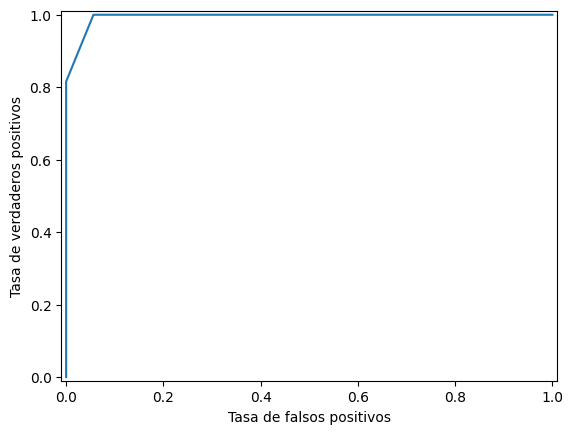

In [115]:
# Predecimos los valores
y_hat = tree.predict(X_test)

# Calculamos la matriz de confusión
cm = confusion_matrix(y_test, y_hat)
print("La matriz de confusión: \n", cm)
print("\n")

# Calculamos el reporte de clasificación
cr = classification_report(y_test, y_hat)
print("Reporte de clasificación: \n", cr)

# Calculamos la probabilidad del modelo
prob_total = tree.predict_proba(X_test)[:, -1] # para llevarlo a 1-d

# Realizamos la curva roc
fpr_total, tpr_total, _ = roc_curve(y_true=y_test, y_score=prob_total)

# Ploteamos la curva
plt.plot(fpr_total, tpr_total, label="Modelo con todos los atributos y árbol podado")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel("Tasa de falsos positivos")
plt.ylabel("Tasa de verdaderos positivos")

# Calculamos el auc
print(f"Modelo con todos los atributos AUC: {auc(fpr_total, tpr_total)}")

- Con este nivel de profundidad, podemos decir que el score es excelente.

### Random Forest
- Plantemos este modelo con el mismo criterio y el mismo nivel de profundidad para comparar con este último modelo.

In [116]:
# Planteamos el split
# Separando nuestro dataset en entrenamiento y testeo
X_train, X_test, y_train, y_test = train_test_split(X_dummies, y, test_size=test_split, random_state=seed)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((195899, 70), (83957, 70), (195899,), (83957,))

In [117]:
# Planteamos clasificador con Gini como criterio
forest = RandomForestClassifier(criterion='gini', max_depth=4, random_state=seed)
forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=4, random_state=17)

La matriz de confusión: 
 [[58657  2813]
 [ 1183 21304]]


Reporte de clasificación: 
               precision    recall  f1-score   support

           0       0.98      0.95      0.97     61470
           1       0.88      0.95      0.91     22487

    accuracy                           0.95     83957
   macro avg       0.93      0.95      0.94     83957
weighted avg       0.95      0.95      0.95     83957

Modelo con todos los atributos AUC: 0.9923688631362875


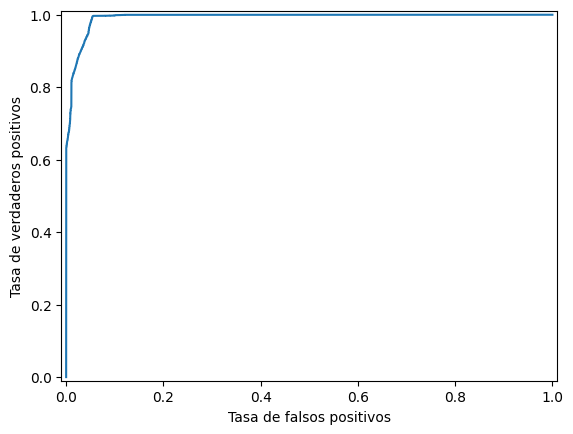

In [118]:
# Predecimos los valores
y_hat = forest.predict(X_test)

# Calculamos la matriz de confusión
cm = confusion_matrix(y_test, y_hat)
print("La matriz de confusión: \n", cm)
print("\n")

# Calculamos el reporte de clasificación
cr = classification_report(y_test, y_hat)
print("Reporte de clasificación: \n", cr)

# Calculamos la probabilidad del modelo
prob_total = forest.predict_proba(X_test)[:, -1] # para llevarlo a 1-d

# Realizamos la curva roc
fpr_total, tpr_total, _ = roc_curve(y_true=y_test, y_score=prob_total)

# Ploteamos la curva
plt.plot(fpr_total, tpr_total, label="Modelo con todos los atributos y árbol podado")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel("Tasa de falsos positivos")
plt.ylabel("Tasa de verdaderos positivos")

# Calculamos el auc
print(f"Modelo con todos los atributos AUC: {auc(fpr_total, tpr_total)}")

- No cuenta con una mejora al anterior, pero tiene un excelente valor.
- Vamos a elegirlo en relación del DecisionTree ya que RandomForest contraresta el sobreajuste del Árbol.

## SVM
- No converge, probablemente porque las clases no son linealmente separables.
- No se calcularán scores para este tipo de modelos.

## Red Neuronal
- Vamos a utilizar un perceptrón como red neuronal de dos capas para ver cómo se comporta con las variables dummies.

In [119]:
# Planteamos el split
# Pasamos y a values
y = credit['Credit Score'].values

# Separando nuestro dataset en entrenamiento y testeo
X_train, X_test, y_train, y_test = train_test_split(X_dummies, y, test_size=test_split, random_state=seed)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((195899, 70), (83957, 70), (195899,), (83957,))

In [120]:
# Escalamos las variables
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [121]:
# Acomodamos los formatos
X_train = torch.from_numpy(X_train)
X_train = X_train.to(torch.float32)
X_test = torch.from_numpy(X_test)
X_test = X_test.to(torch.float32)

In [122]:
# También para la variable de salida
y_train = torch.from_numpy(y_train)
y_train = y_train.to(torch.float32)
y_test = torch.from_numpy(y_test)
y_test = y_test.to(torch.float32)

In [123]:
# Creamos el perceptron para regresion
class perceptron(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # En este caso solo nos quedamos con los datos lineales
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(70, 1),
        )
    
    def forward(self, x):

        # Pasamos por el perceptron
        y_prob = self.layers(x)

        return y_prob

In [124]:
# Creamos el perceptron para regresion
net = perceptron()
# Usamos como funcion de error a MSE
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.00001)

# Creamos una lista que mida el error en el loop
errors = list()

# Realizamos la iteracion
for epoch in range(10000):

    values = np.random.permutation(X_train.shape[0]) 

    subsetX = X_train[values[:50]]
    subsety = y_train[values[:50]]

    # Limpiamos los gradientes
    optimizer.zero_grad()

    # Obtenemos todas las predicciones
    outputs = net(subsetX)

    # Calculamos el error
    loss = criterion(outputs, subsety)

    # Propagamos el error
    loss.backward()

    # Optimizamos los parametros
    optimizer.step()

    errors.append(loss.item())

/Users/manoloacademia/Documents/CEIA/02 - Aprendizaje de Máquinas 1/.venv/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([50])) that is different to the input size (torch.Size([50, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


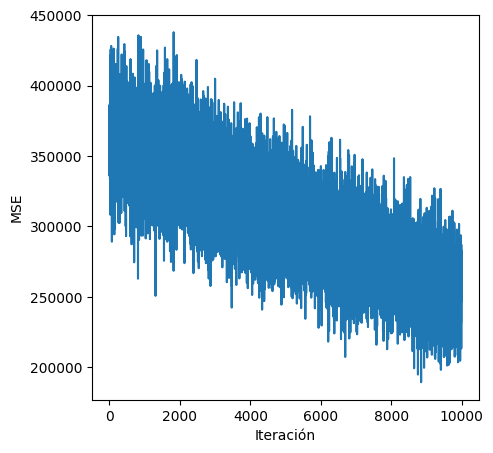

In [125]:
fig, ax = plt.subplots(figsize=(5,5))

ax.plot(errors)
ax.set_ylabel("MSE")
ax.set_xlabel("Iteración")
#ax.set_ylim([0, 300])
plt.show();

- Tenemos un mal valor de MSE para este perceptón.
- En comparación con el MSE del modelo de regresión lineal con todas las features, se comporta mucho mejor con regresión lineal.

## Resultado

Afortunadamente, tenemos un buen resultado con este dataset para predecir si damos o no un préstamo a un nuevo cliente.

Para regresión, se tienen los mejores scores para un algoritmo de regresión lineal, usando las variables categóricas sumadas a las 4 máscaras para las variables de distribución extraña o quitando algunos features con p-value elevados.

Para clasificación, el criterio de clasificaión lo defino mediante un algoritmo de RandomForest de profundidad 4. Como se comentó en ese apartado, el árbol de clasificación con esa profundidad tiene una excelente performance, pero podemos estar en un sobre-ajuste.

SVM no pudo utilzarse. Posiblemente a la imposibilidad de separación entre las variables.

## Conclusión

Con significativos scores, las variables categóricas tienen una importancia muy grande ya sea usando el target como valor o clase.

## Trabajo futuro

Realizar feature engineering para entender si se pueden enmascarar las otras variables numéricas y dar más explicabilidad a la regresión con estas entradas.

Analizar si es posible aplicar SVM amen de las complicaciones actuales.

Sería bueno afrontar un análisis más profundo con redes neuronales, debido a la cantidad de datos actuales. Seguro puede mejorar el score.